# Network Analysis of Harry Potter Book Series

## Setup

In [2]:
!pip install -r requirements.txt
!pip install matplotlib
!pip install netwulf networkx

     |████████████████████████████████| 115 kB 31.3 MB/s 
     |████████████████████████████████| 125 kB 31.6 MB/s 
     |████████████████████████████████| 1.6 MB 41.9 MB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=fa000ce6e5581352a3b4650da12ff009172d150dae006a1517fd39b46426fd90
  Stored in directory: /root/.cache/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Not uninstalling decorator at /shared-libs/python3.8/py-core/lib/python3.8/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 236 kB 13.0 MB/s 
  Using cached decor

In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
import nltk
from clean_books import clean_book
from sentiment import *
import os, re, sys
from difflib import SequenceMatcher
from tqdm import tqdm
import itertools
import networkx as nx
import netwulf as nw
from collections import defaultdict

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Function Definitions for Text Analysis

Some useful function can be found in `sentiment.py`:

`happiness(doc)` takes a list of words and computes the average happiness score using the Hedonometer

`emotion_score(doc)` takes a list of words and computes a dictionary of average emotion scores among the emotions: _Anger, Anticipation,	Disgust, Fear, Joy, Sadness, Surprise_ and _Trust_

`vader_sentiment(doc)` takes a list of words and/or sentences and computes the average VADER compund score

`TF_IDF(docs_to_analyse, all_docs)` computes TF and TF-IDF score of terms in docs_to_analyse. all_docs are used to comput IDF scores 


## Scraping the internet for information
Below the chapter titles of the the books and characters by house has been scraped from the internet with the script `scrape_book_chapters.py` and `scrape_characters_by_house`

In [3]:
chapter_info = pd.read_pickle('data/chapter_dataframe.pkl')
#Add book number to chapters
idx = chapter_info.index[chapter_info["Local Chapter"] == 1]
for i in range(7):
    chapter_info.loc[idx[i]:(idx[i+1] if i+1 < len(idx) else None), "Book"] = int(i+1)
chapter_info

,Global Chapter,Local Chapter,Title,Approx Story Time,Book
0,1,1,The Boy Who Lived,1981-11-01,1.0
1,2,2,The Vanishing Glass,1991-06-23,1.0
2,3,3,The Letters from No One,1991-07-23,1.0
3,4,4,The Keeper of Keys,1991-07-31,1.0
4,5,5,Diagon Alley,1991-07-31,1.0
...,...,...,...,...,...
194,195,33,The Prince’s Tale,1998-05-02,7.0
195,196,34,The Forest Again,1998-05-02,7.0
196,197,35,King’s Cross,1998-05-02,7.0
197,198,36,The Flaw in the Plan,1998-05-02,7.0


In [4]:
with open('data/characters_by_house.pkl', 'rb') as file:
    characters_by_communities = pkl.load(file)

# characters_by_communities

# Splitting Book Chapters Into Documents

In [195]:
# Get a list of paths to books
path = "data/books/"
books = os.listdir(path)
books.sort()
books_in_chapters = []

for i in tqdm(range(7), desc='Book Loop'): # For every book
    # Remove HTML TAGS and double spacing
    print("\n", file = sys.stderr)
    book = clean_book(path + books[i]) 
    # book = re.sub('\n{2,}', '\n', book)
    # Get chapters of book
    chapters = [chapter.upper() for chapter in chapter_info.loc[chapter_info["Book"] == i+1, "Title"]]

    # Split Lines and remove lines including page numbering or J.K. Rowling
    lines = [line for line in book.splitlines() if not re.search(r'Page \| [0-9]{1,} | J.K. Rowling', line)]        

    # Find lines with the title of the chapters
    chapter_idx = []
    for chapter in chapters:
        # Use SequenceMatcher to find similarity between line and a given chapter. Threshold of 0.6
        ties = [(i, line) for i, line in enumerate(lines) if SequenceMatcher(None, chapter, line).ratio() >.6]

        # If 2 or more lines have a similarity of above .6 with the chapter find the most similar
        idx, title = ties[np.argmax([SequenceMatcher(None, chapter, title).ratio() for _, title in ties])]
        chapter_idx.append(idx)
        print(title, chapter, file = sys.stderr)

    print("\n", file = sys.stderr)  
    # Get a list of chapters - List of strings
    chapters = ["\n".join(lines[chapter_idx[i]:chapter_idx[i+1] if len(chapters) > i+1 else None]) for i in range(len(chapter_idx))]

    chapters[:] = [re.sub(r'[a-zA-Z](\s){0,}(\n){2}','\n', re.sub(r'(\n){3,}','\n\n', chapter)) for chapter in chapters]
    books_in_chapters.append(chapters)  

pkl.dump(books_in_chapters, open("data/books_in_chapters.pkl","wb")) 

Book Loop:   0%|          | 0/7 [00:00<?, ?it/s]

THE BOY WHO LIVED  THE BOY WHO LIVED
THE VANASHING GLASS  THE VANISHING GLASS
THE LETTERS FROM NO ONE  THE LETTERS FROM NO ONE
THE KEEPER OF KEYS  THE KEEPER OF KEYS
DIAGON ALLEY  DIAGON ALLEY
THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS  THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
THE SORTING HAT  THE SORTING HAT
THE POTIONS MASTER  THE POTIONS MASTER
THE MIDNIGHT DUEL  THE MIDNIGHT DUEL
HALLOWE'EN  HALLOWE'EN
QUIDDITCH  QUIDDITCH
THE MIRROR OF ERISED  THE MIRROR OF ERISED
NICOLAS FLAMEL  NICOLAS FLAMEL
NORBERT THE NORWEGIAN RIDGEBACK  NORBERT THE NORWEGIAN RIDGEBACK
THE FORBIDDEN FOREST  THE FORBIDDEN FOREST
THROUGH THE TRAPDOOR  THROUGH THE TRAPDOOR
THE MAN WITH TWO FACES  THE MAN WITH TWO FACES


Book Loop:  14%|█▍        | 1/7 [00:08<00:53,  8.93s/it]

THE WORST BIRTHDAY  THE WORST BIRTHDAY
DOBBY’S WARNING  DOBBY’S WARNING
THE BURROW  THE BURROW
AT FLOURISH AND BLOTTS  AT FLOURISH AND BLOTTS
THE WHOMPING WILLOW  THE WHOM

# Preprocessing and Cleaning

 Remove stopwords etc.

In [6]:
from nltk.tokenize import RegexpTokenizer
with open('data/books_in_chapters.pkl', 'rb') as file:
    books_in_chapters = pkl.load(file)

SW = stopwords.words("english")
books_in_chapters_clean = books_in_chapters.copy()
for book in range(len(books_in_chapters)):
    for chapter in range(len(books_in_chapters_clean[book])):
        books_in_chapters_clean[book][chapter] = re.sub(r".*\n", "", books_in_chapters_clean[book][chapter], 1) # remove chapter title 
        # books_in_chapters_clean[book][chapter] = books_in_chapters_clean[book][chapter].replace(" \n", ". ", 1) # set punctuation after chapter title
        words = books_in_chapters_clean[book][chapter].split(' ')
        words = [word for word in words if word.lower() not in SW]
        tokenizer = RegexpTokenizer(r'\w+[,\.!\?:]?')
        books_in_chapters_clean[book][chapter] = " ".join(tokenizer.tokenize(" ".join(words)))

# pkl.dump(books_in_chapters, open("data/books_in_chapters_clean.pkl","wb"))
# print(books_in_chapters_clean[1][0])

In [5]:
with open('data/books_in_chapters.pkl', 'rb') as file:
    books_in_chapters = pkl.load(file)
test = books_in_chapters[1][0]
# test.replace(" \n", r". ", 1)
# re.sub(r".*\n", "", test, 1)

# Actor Extraction
We use the character names that we scraped from the web as search words to see if we can find them in each chapter, where they appear.

Because the characters can be called by different names and nicknames we "normalize" the names in the book text to begin with.
We make it so all names and nicknames are replaced with the corresponding first name of the character in lower case e.g. _'voldemort'_ is sometimes called _'voldemort'_ or _'he-who-must-not-be-names'_ or _'tom riddle'_. We map them all to _'voldemort'_ 

In [6]:
with open('data/books_in_chapters.pkl', 'rb') as file:
    books_in_chapters = pkl.load(file)
characters_by_communities_reverse = {val:key for key, value in characters_by_communities.items() for val in value if key != 'House Unknown'}
characters_by_communities_reverse["Mr. Weasley"] = 'Gryffindor'
characters_by_communities_reverse["Mrs. Weasley"] = 'Gryffindor'
characters_by_communities_reverse["Crabbe"] = 'Slytherin'
characters_by_communities_reverse["Goyle"] = 'Slytherin'
characters_by_communities_reverse["Sirius"] = 'Gryffindor'
del characters_by_communities_reverse["Albus Potter"]; del characters_by_communities_reverse["Su Li"]
special_names = {'He-Who-Must-Not-Be-Named':'Voldemort', 'You-Know-Who':'Voldemort','Tom Riddle': 'Voldemort', 'Tom Marvolo Riddle':'Voldemort',
                'Peter Pettigrew':'Wormtail', 'Weasley':'Ron', 'Potter':'Harry', 'Malfoy':'Draco', 'Tonks':'Nymphadora',
                 'Mr. Weasley':'mr. Weasley', 'Mrs. Weasley':'mrs. Weasley', 'Mr. Potter': 'Harry', 'Pettigrew':'Wormtail', 'Lupin': 'Remus'}

names      = {name: name.split(" ")[0] 
                for name in characters_by_communities_reverse.keys()
                if ('the ' not in name.lower()) and ('.' not in name.lower()) and ('miss ' not in name.lower()) and ('sir ' not in name.lower()) }


firstname     = {name.split(" ")[-1]: name.split(" ")[0] 
                for name in characters_by_communities_reverse.keys()
                if ('the ' not in name.lower()) and ('.' not in name.lower()) and ('miss ' not in name.lower()) and ('sir ' not in name.lower()) }

# characters_by_communities_reverse
names.update(firstname)
names.update(special_names)
del names["Black"]; del names["Riddle"]; del names["Merlin"]; del names["Slytherin"]; del names["Gryffindor"]; del names["Ravenclaw"]; del names["Hufflepuff"]
regexPattern = "|".join(names.keys())

# surnames

books_in_chapters_names = [[re.sub(regexPattern, lambda name: names[name.group()], chapter ) for chapter in book] for book in books_in_chapters]



In [8]:
chapters = [chapter for book in books_in_chapters_names for chapter in book]
interactions = defaultdict(lambda: defaultdict(list))
names_ = set(list(names.values()) + ['he', 'she'])
r = 3
for j, chapter in tqdm(enumerate(chapters[:-1])):
    speeches, contexts, sources = [], [], []
    split = chapter.split("\n\n")
    for line in split:
        line = re.sub('\n', ' ', line)
        S = list(filter(None, re.split(r'“|”', re.sub('“', '“_', line))))
        if len(S) > 1:
            speech = ' '.join([s[1:] for s in S if s[0] == '_'])
            context = ' '.join([s for s in S if s[0] != '_'])
            N = [word for word in re.split(r'\s|\,|\.|\!|\?', context) if word in names_]
            source = None if not N else N[0]
            speeches.append(speech); contexts.append(context); sources.append(source)
        else:
            speeches.append(None); contexts.append(line); sources.append(None)

    
    for i in range(len(speeches)):
        speech, source, context = speeches[i], sources[i], contexts[i]
    
        if speech and source and source != 'he' and source != 'she':
            targets = set(sources[i-r:i] + sources[i+1:i+r+1]).difference(set((source,None, 'he', 'she')))
            
            for target in targets:
                
 
                interactions[source][target].append((speech, j))



198it [00:00, 382.29it/s]


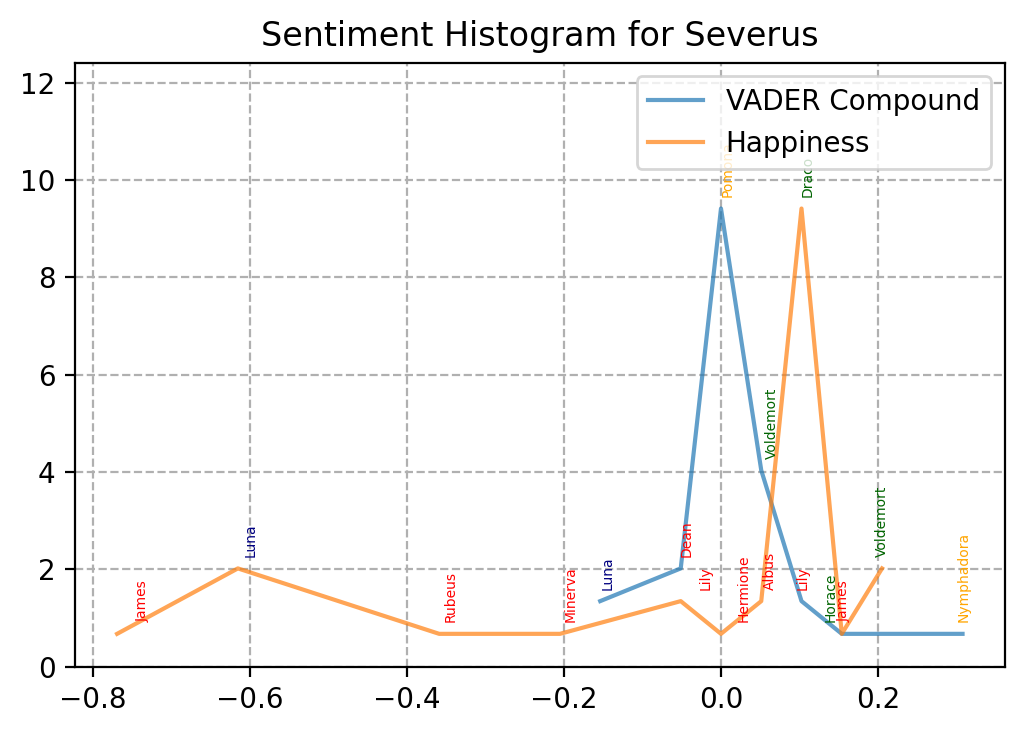

In [9]:
def get_scores(source):
    targets = []
    C, H = [], []

    for target in interactions[source].keys():
        
        speeches, chapter = zip(*interactions[source][target])
        compound = [vader_sentiment(re.split(r'[\.\!\?]', re.sub(r'  |\\', ' ', speech))) for speech in speeches]
        happy = [happiness([word.lower() for word in re.split(r'[\s\.,\!\?]', speech) if word.isalpha()]) for speech in speeches]
        compound = np.mean(compound)
        happy = (np.mean(happy) - 1)/(9-1) * (1 - (-1)) -1
        C.append(compound); H.append(happy); targets.append(target)
    return C, H, targets


source = 'Severus'
C, H, targets = get_scores(source)
import matplotlib.pyplot as plt
houses = {val:characters_by_communities_reverse[key] for key, val in names.items() if key in characters_by_communities_reverse.keys()}
colors = {'Gryffindor': 'red', 'Slytherin': 'darkgreen', 'Hufflepuff': 'orange', 'Ravenclaw': 'navy'}
nbins = 40
bins = np.linspace(-1, 1, nbins)
hist, edges = np.histogram(C, bins = bins, density = True )
x = (edges[1:] + edges[:-1])/2.
# remove 0 entries
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j > 0])

bins = np.linspace(-1, 1, nbins)
hist, edges = np.histogram(H, bins = bins, density = True)
z = (edges[1:] + edges[:-1])/2.
# remove 0 entries
zz, ww = zip(*[(i,j) for (i,j) in zip(z, hist) if j > 0])


fig, ax = plt.subplots(dpi = 200)
ax.plot(xx,yy, label = "VADER Compound", alpha = .7)
ax.plot(zz,ww,label = "Happiness", alpha = .7)
ax.grid(linestyle = '--')
for i in range(len(xx)):
    index_C = np.argmin(abs(np.array(C) - xx[i]))
    valC = C[index_C]
    ax.annotate(targets[index_C], (valC, yy[i] +.3), fontsize = 5, rotation = 90, color = colors[houses[targets[index_C]]])

for i in range(len(zz)):
    index_H = np.argmin(abs(np.array(H) - zz[i]))
    valH = H[index_H]
    ax.annotate(targets[index_H], (valH, ww[i]+ .3), fontsize = 5, rotation = 90, color = colors[houses[targets[index_H]]])
ax.set_ylim(0, max(max(yy),max(ww))+3)
ax.legend()   
ax.set_title(f"Sentiment Histogram for {source}")

plt.show()



    

In [244]:
edges = []

for source in interactions.keys():
    C, H, targets = get_scores(source)
    if len(C) > 1:
        for i in range(len(C)):
            C_ = [c for j, c in enumerate(C) if i != j]
            H_ = [h for j, h in enumerate(H) if i != j]
            
            # weight1 = (C[i] - np.mean(C_)) * (1/np.std(C_) if np.std(C_) != 0 else 0)
            # weight2 = (H[i] - np.mean(H_)) * (1/np.std(H_) if np.std(H_) != 0 else 0)
            weight1 = C[i]
            weight2 = H[i]
            edges.append((source, targets[i], {'weight':np.mean([weight1, weight2])}))
            # print(source, targets[i], weight1, weight2)
G = nx.DiGraph()
G.add_edges_from(edges)


In [245]:
colors = {'Gryffindor': 'red', 'Slytherin': 'darkgreen', 'Hufflepuff': 'orange', 'Ravenclaw': 'navy'}
C = {val:colors[characters_by_communities_reverse[key]] for key, val in names.items() if key in characters_by_communities_reverse.keys()}
nx.set_node_attributes(G, C, 'group')





In [248]:
stylized_network_2, config = nw.visualize(G, plot_in_cell_below=False)

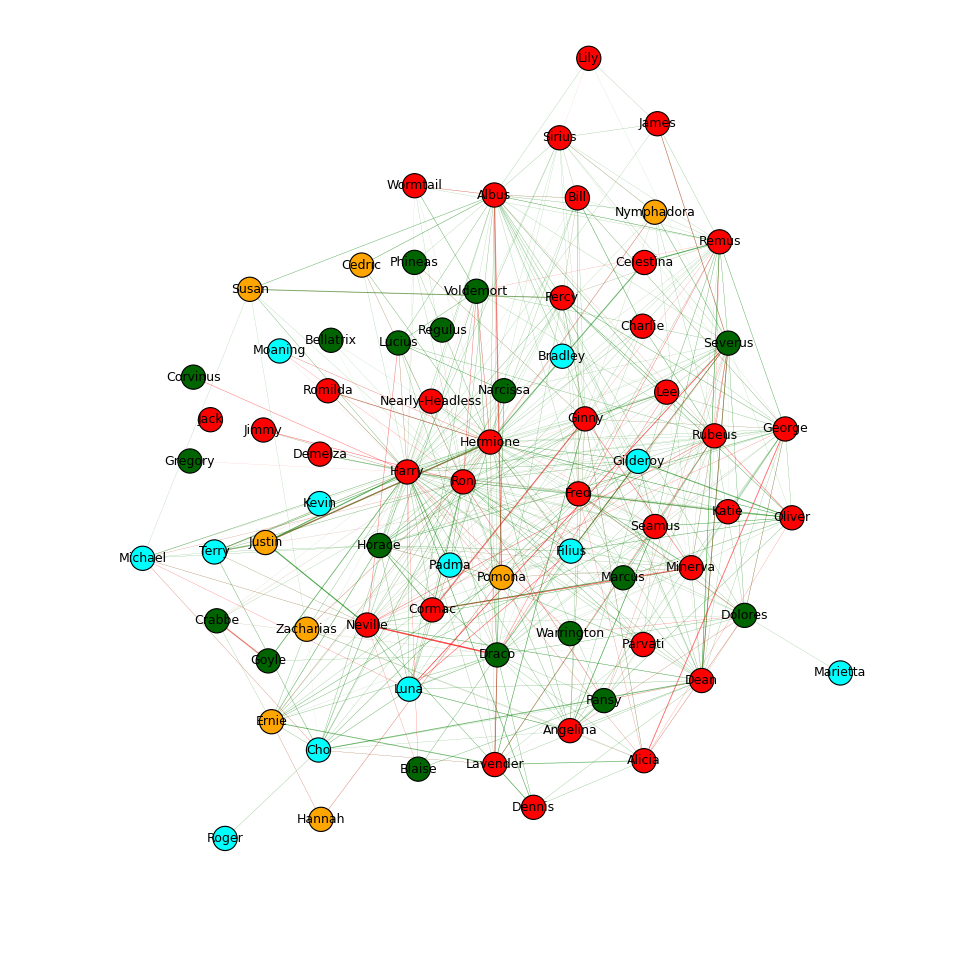

In [249]:
for D in stylized_network_2['links']:
    D['width'] = D['weight']
    D['color'] = 'red' if D['weight'] < 0 else 'green'
for D in stylized_network_2['nodes']:
    D['color'] = '#00FFFF' if D['color'] == '#000080' else D['color']
fig, ax = plt.subplots(dpi = 300)
nw.draw_netwulf(stylized_network_2, fig = fig, ax = ax)
for source in G.nodes():
    nw.add_node_label(ax, stylized_network_2, source, fontsize = 3)
# with open('network.pkl', 'wb') as file:
#     pkl.dump(stylized_network_2, file)


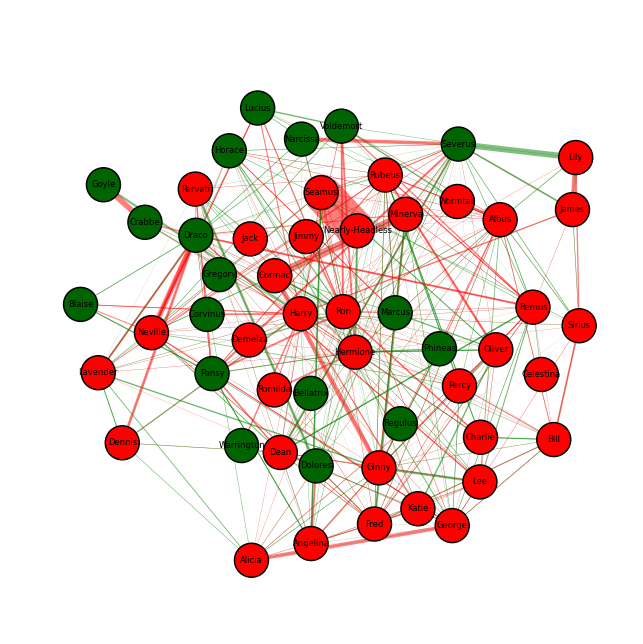

In [242]:
def plot_network(network_dict, houses = None , names = None):
    colors = {'Gryffindor': '#ff0000', 'Slytherin': '#006400', 'Hufflepuff': '#ffa500', 'Ravenclaw': '#00FFFF'}
    stylized_network2 = network_dict.copy()
    
    good_colors = [colors[house] for house in houses] if houses else colors.values()
    nodes, links, names_ = [], [], []
    names = names if names else [node['id'] for node in stylized_network2['nodes']]
    for node in stylized_network2['nodes']:
        if node['id'] in names and node['color'] in good_colors: 
            
            nodes.append(node)
            names_.append(node['id'])
    
    for link in stylized_network2['links']:
        if link['source'] in names_ and link['target'] in names_:
            links.append(link)

    stylized_network2['nodes'] = nodes
    stylized_network2['links'] = links
    fig, ax = plt.subplots(dpi = 200)
    nw.draw_netwulf(stylized_network2, fig = fig, ax = ax)
    for source in stylized_network2['nodes']:
        nw.add_node_label(ax, stylized_network2, source['id'], fontsize = 3)
plot_network(stylized_network_, ['Gryffindor','Slytherin'])
# stylized_network_['nodes']

In [255]:
edges = [(a,b, attr) for a, b, attrs in G.edges(data=True) if attrs["weight"] >= 500]
G2 = nx.DiGraph()
G2.add_edges_from(edges)
colors = {'Gryffindor': 'red', 'Slytherin': 'darkgreen', 'Hufflepuff': 'orange', 'Ravenclaw': 'navy'}
C = {val:colors[characters_by_communities_reverse[key]] for key, val in names.items() if key in characters_by_communities_reverse.keys()}
nx.set_node_attributes(G, C, 'group')
nw.visualize(G, plot_in_cell_below=False)

(None, None)

In [15]:
interactions.keys()
houses = {val:characters_by_communities_reverse[key] for key, val in names.items() if key in characters_by_communities_reverse.keys()}
houses
for k in interactions.keys():
    print(k, houses[k])

Albus Gryffindor
Minerva Gryffindor
Rubeus Gryffindor
Harry Gryffindor
Lavender Gryffindor
Ron Gryffindor
Hermione Gryffindor
Draco Slytherin
Neville Gryffindor
Percy Gryffindor
Seamus Gryffindor
Nearly-Headless Gryffindor
Severus Slytherin
Parvati Gryffindor
Pansy Slytherin
Oliver Gryffindor
George Gryffindor
Fred Gryffindor
Filius Ravenclaw
Angelina Gryffindor
Lee Gryffindor
Dean Gryffindor
Marcus Slytherin
Voldemort Slytherin
Ginny Gryffindor
Gilderoy Ravenclaw
Pomona Hufflepuff
Dennis Gryffindor
Crabbe Slytherin
Moaning Ravenclaw
Alicia Gryffindor
Ernie Hufflepuff
Hannah Hufflepuff
Lucius Slytherin
Remus Gryffindor
Katie Gryffindor
Sirius Gryffindor
Wormtail Gryffindor
Bill Gryffindor
Charlie Gryffindor
Cedric Hufflepuff
Kevin Ravenclaw
Cho Ravenclaw
Padma Ravenclaw
Nymphadora Hufflepuff
Susan Hufflepuff
Luna Ravenclaw
Dolores Slytherin
Michael Ravenclaw
Zacharias Hufflepuff
Terry Ravenclaw
Justin Hufflepuff
Phineas Slytherin
Roger Ravenclaw
Marietta Ravenclaw
James Gryffindor
Lily

In [47]:
def extract_characters_by_chapter(names, books):
    '''
        Params:
        names:    List of character names to search for
        books:    list of books. Each book is a list of chapters. 
                  e.g. to get text from chap. 1 in book 1 do books[0][0]

        Returns: Dictionary mapping the title of a chapter to a list of
                 the characters appearing in the chapter. If a character
                 appear multiple times in a chapter, they will appear
                 multiple times in the dictionary list for that chapter.
    '''
    characters_in_chapter = {}

    global_chapter = 0

    for book in tqdm(books):
        for chapter in book:
            global_chapter += 1
            characters_in_chapter[global_chapter] = {}

            for name in names:
                search_results = re.findall(f' {name}[.,!?\s] ', chapter)
                if search_results:
                    characters_in_chapter[global_chapter][name] = len(search_results)

    return characters_in_chapter


In [49]:
search_names = set(names.values())
books = books_in_chapters_clean_names

characters_in_chapter = extract_characters_by_chapter(search_names, books)
characters_in_chapter

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


{1: {'Albus': 12, 'Voldemort': 1, 'Minerva': 7, 'Rubeus': 1, 'Harry': 4},
 2: {'Harry': 15},
 3: {'Malcolm': 1, 'Harry': 12, 'Dennis': 1},
 4: {'Albus': 1, 'Susan': 1, 'James': 1, 'Rubeus': 12, 'Harry': 19},
 5: {'Albus': 1, 'Lavender': 1, 'Rubeus': 30, 'Harry': 35},
 6: {'Ginny': 3,
  'Albus': 1,
  'George': 3,
  'Hermione': 4,
  'Draco': 1,
  'Fred': 3,
  'Lee': 1,
  'Ron': 24,
  'Rubeus': 3,
  'Harry': 27,
  'Goyle': 1},
 7: {'Albus': 5,
  'Severus': 1,
  'Hannah': 1,
  'Percy': 7,
  'Minerva': 2,
  'Neville': 3,
  'Seamus': 1,
  'Hermione': 1,
  'Draco': 1,
  'Fred': 1,
  'Ron': 3,
  'Rubeus': 3,
  'Harry': 3,
  'Goyle': 1},
 8: {'Filius': 3,
  'Severus': 2,
  'Pomona': 1,
  'Minerva': 1,
  'Neville': 2,
  'Crabbe': 1,
  'George': 1,
  'Hermione': 1,
  'Draco': 2,
  'Ron': 7,
  'Rubeus': 7,
  'Harry': 8,
  'Goyle': 1},
 9: {'Filius': 1,
  'Parvati': 1,
  'Oliver': 3,
  'Albus': 1,
  'Minerva': 2,
  'Neville': 8,
  'Crabbe': 1,
  'Hermione': 3,
  'Draco': 9,
  'Fred': 1,
  'mr. Weas

# Creating the Network

In [50]:
# Computer character nodes
character_nodes = list(search_names)

coorcurrence_edges = []

df_dict = {"source": [], "target": [], "weight": [], "global_chapter":[]}
# Compute edges as coorcurrences in chapters
for chapter, characters in characters_in_chapter.items():
    print(characters)
    for character, occurences in characters.items():
        other_characters = list(characters.keys())
        other_characters.remove(character)
        
        for o_char in other_characters:
            if character != o_char:
                coorcurrence_edges += [(character, o_char)]
                df_dict["source"].append(character)
                df_dict["target"].append(o_char) 
                df_dict["weight"].append(0)
                df_dict["global_chapter"].append(chapter)

df = pd.DataFrame(df_dict)
# df

{'Albus': 12, 'Voldemort': 1, 'Minerva': 7, 'Rubeus': 1, 'Harry': 4}
{'Harry': 15}
{'Malcolm': 1, 'Harry': 12, 'Dennis': 1}
{'Albus': 1, 'Susan': 1, 'James': 1, 'Rubeus': 12, 'Harry': 19}
{'Albus': 1, 'Lavender': 1, 'Rubeus': 30, 'Harry': 35}
{'Ginny': 3, 'Albus': 1, 'George': 3, 'Hermione': 4, 'Draco': 1, 'Fred': 3, 'Lee': 1, 'Ron': 24, 'Rubeus': 3, 'Harry': 27, 'Goyle': 1}
{'Albus': 5, 'Severus': 1, 'Hannah': 1, 'Percy': 7, 'Minerva': 2, 'Neville': 3, 'Seamus': 1, 'Hermione': 1, 'Draco': 1, 'Fred': 1, 'Ron': 3, 'Rubeus': 3, 'Harry': 3, 'Goyle': 1}
{'Filius': 3, 'Severus': 2, 'Pomona': 1, 'Minerva': 1, 'Neville': 2, 'Crabbe': 1, 'George': 1, 'Hermione': 1, 'Draco': 2, 'Ron': 7, 'Rubeus': 7, 'Harry': 8, 'Goyle': 1}
{'Filius': 1, 'Parvati': 1, 'Oliver': 3, 'Albus': 1, 'Minerva': 2, 'Neville': 8, 'Crabbe': 1, 'Hermione': 3, 'Draco': 9, 'Fred': 1, 'mr. Weasley': 1, 'Ron': 10, 'Rubeus': 1, 'Harry': 17, 'Goyle': 3}
{'Filius': 3, 'Oliver': 9, 'Minerva': 2, 'Charlie': 1, 'Hermione': 8, 'Draco

In [51]:
# Undirected graph - Add edge between 2 characters if the ever cooccur
# The weight is the the sum of log of the min number of mentions of the 2 characters in a chapter
from collections import defaultdict
character_nodes = list(search_names)

coorcurrence_edges = []

df_dict = defaultdict(lambda: defaultdict(float))
# Compute edges as coorcurrences in chapters
for chapter, characters in characters_in_chapter.items():
    vals = list(
        characters.values())
    characters = list(characters.items())
    
    for i in range(len(characters) - 1):
        character, count = characters[i]
        for other_character, other_count in characters[i+1:]:
            if min((count, other_count)) > 1:
                source = min((character,other_character))
                target = max((character,other_character))
                weight = np.log(min((count, other_count)))
                df_dict[source][target] += weight
s, t, w = [], [], []
for source, val in df_dict.items():
    for target, weight in val.items():
        s.append(source)
        t.append(target) 
        w.append(weight)
df = pd.DataFrame({"source":s, 'target':t, 'weight':w})
df.head(10)


,source,target,weight
0,Albus,Minerva,20.069772
1,Albus,Harry,126.245261
2,Albus,Percy,9.431883
3,Albus,Neville,9.688312
4,Albus,Ron,74.586397
5,Albus,Rubeus,28.895037
6,Albus,Severus,30.573468
7,Albus,Hermione,68.972707
8,Albus,Draco,22.403609
9,Albus,Ginny,17.682029


In [178]:

with open('data/chapter_dataframe.pkl', 'rb') as file:
    chapter_dataframe = pkl.load(file)
# chapter_dataframe.columns
joined_df = df.join(chapter_dataframe.set_index('Global Chapter'), on='global_chapter', how='left')
joined_df.head(20)

,source,target,weight,global_chapter,Local Chapter,Title,Approx Story Time
0,Albus,Minerva,2.197225,1,1,The Boy Who Lived,1981-11-01
1,Albus,Rubeus,1.386294,1,1,The Boy Who Lived,1981-11-01
2,Albus,Harry,1.945910,1,1,The Boy Who Lived,1981-11-01
3,Albus,Voldemort,0.693147,1,1,The Boy Who Lived,1981-11-01
4,Minerva,Rubeus,1.386294,1,1,The Boy Who Lived,1981-11-01
5,Minerva,Harry,1.945910,1,1,The Boy Who Lived,1981-11-01
6,Minerva,Voldemort,0.693147,1,1,The Boy Who Lived,1981-11-01
7,Rubeus,Harry,1.386294,1,1,The Boy Who Lived,1981-11-01
8,Rubeus,Voldemort,0.693147,1,1,The Boy Who Lived,1981-11-01
9,Harry,Voldemort,0.693147,1,1,The Boy Who Lived,1981-11-01


In [130]:
# G = nx.convert_matrix.from_pandas_edgelist(df[:], source = "source", target = "target", edge_attr  = 'weight', create_using=nx.Graph)
# del characters_by_communities_reverse['Albus Potter']

C = {val:characters_by_communities_reverse[key] for key, val in names.items() if key in characters_by_communities_reverse.keys()}
nx.set_node_attributes(G, C, 'house')
S = []
for node, data in G.nodes(data = True):
    edges = G.out_edges(node, data = True)
    houses = {'Gryffindor': [], 'Slytherin': [], 'Hufflepuff': [], 'Ravenclaw': []}
    
    for _, target, data2 in edges:
        
        houses[C[target]].append(data2['weight'])
    for key in houses.keys():
        houses[key] = np.sum(houses[key])
        # print(np.mean(houses[key]))
    S.append((node, houses))

In [133]:
houses = {'Gryffindor': [], 'Slytherin': [], 'Hufflepuff': [], 'Ravenclaw': []}
for H in houses.keys():
    houses = {'Gryffindor': [], 'Slytherin': [], 'Hufflepuff': [], 'Ravenclaw': []}
    [houses[house].append(vader) for name, data in S if C[name] == H for house, vader in data.items()]
    for key in houses.keys():
        houses[key] = np.mean(houses[key])
    print(H, houses)

Gryffindor {'Gryffindor': 1.027252674551362, 'Slytherin': 0.07712578877633786, 'Hufflepuff': 0.10398528446115289, 'Ravenclaw': 0.15620372866137905}
Slytherin {'Gryffindor': 0.40907336356295115, 'Slytherin': 0.37645027226041927, 'Hufflepuff': 0.12896470588235295, 'Ravenclaw': -0.0236764705882353}
Hufflepuff {'Gryffindor': 0.5522438743451799, 'Slytherin': 0.04259999999999999, 'Hufflepuff': -0.061918750000000015, 'Ravenclaw': 0.091615}
Ravenclaw {'Gryffindor': 0.34604502101901363, 'Slytherin': 0.18309702380952383, 'Hufflepuff': -0.0039133333333333286, 'Ravenclaw': 0.010775000000000026}


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85fb65b4-b596-4730-837e-04e86eafe419' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>